#**M_source**

##**Table of Contents**

1. [Overview](#Overview)
2. [Setup & Imports](#Setup-&-Imports)
3. [Data Loading and Preprocessing](#data-loading-and-preprocessing)
4. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
5. [Tokenization](#Tokenization)
6. [Training and Fine-Tuning](#Training-and-Fine-Tuning)
7. [Evaluation](#Evaluation)


## **Overview**

This notebook presents the fine-tuning of **CodeBERT** for binary classification of **C++** code reviews, leveraging real-world data. The model is designed to classify code changes into two labels:

- **0** – High quality, no further review required.
- **1** – Low quality, requires additional review.

## **Setup & Imports**

In [ ]:
# Install required packages
!pip install datasets
!pip install -U transformers
!pip install --upgrade transformers
!pip install datasets --upgrade

In [ ]:
# Import libraries
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig , Trainer, TrainingArguments , EarlyStoppingCallback
from datasets import load_dataset , concatenate_datasets, DatasetDict , Dataset
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score , confusion_matrix , classification_report
from sklearn.utils import resample
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

## **Data Loading and Preprocessing**

### **Load Dataset**
We load the `codereviewer` dataset from Hugging Face, which contains labeled examples for code review classification:

- `y = 0`: High quality, **no** further review required.
- `y = 1`: Low quality, **requires** additional review.

> Note: Language annotations (`lang` field) are available **only** for `y = 0` samples.


In [ ]:
# Load dataset from Hugging Face
train_ds = load_dataset("fasterinnerlooper/codereviewer", "train_quality")
test_ds = load_dataset("fasterinnerlooper/codereviewer", "test_quality")
val_ds = load_dataset("fasterinnerlooper/codereviewer", "validation_quality")

In [ ]:
print(train_ds)
print(test_ds)
print(val_ds)

DatasetDict({
    train: Dataset({
        features: ['oldf', 'patch', 'msg', 'id', 'y', 'idx', 'proj', 'lang'],
        num_rows: 265836
    })
})
DatasetDict({
    train: Dataset({
        features: ['patch', 'y', 'oldf', 'idx', 'id', 'msg', 'proj', 'lang'],
        num_rows: 31252
    })
})
DatasetDict({
    train: Dataset({
        features: ['patch', 'y', 'oldf', 'idx', 'id', 'msg', 'proj', 'lang'],
        num_rows: 31252
    })
})


In [ ]:
# Remove unnecessary columns not needed for training or evaluation
train_ds = train_ds.remove_columns(['msg','id','idx','proj'])
val_ds = val_ds.remove_columns(['msg','id','idx','proj'])
test_ds = test_ds.remove_columns(['msg','id','idx','proj'])

### **Filter for C++ Samples**
To build a language-specific dataset for C++, we apply two filtering strategies:

- For `y = 0`: Use the existing `lang == 'cpp'` metadata.
- For `y = 1`: Use a heuristic function (`is_cpp`) that detects C++-like syntax based on keyword patterns.

In [ ]:
# Filter the datasets to keep only C++ samples
train_ds_cpp = train_ds.filter(lambda example: example['lang'] == 'cpp')
val_ds_cpp = val_ds.filter(lambda example: example['lang'] == 'cpp')
test_ds_cpp = test_ds.filter(lambda example: example['lang'] == 'cpp')

In [ ]:
print(train_ds_cpp)
print(test_ds_cpp)
print(val_ds_cpp)

DatasetDict({
    train: Dataset({
        features: ['oldf', 'patch', 'y', 'lang'],
        num_rows: 11725
    })
})
DatasetDict({
    train: Dataset({
        features: ['patch', 'y', 'oldf', 'lang'],
        num_rows: 3015
    })
})
DatasetDict({
    train: Dataset({
        features: ['patch', 'y', 'oldf', 'lang'],
        num_rows: 3112
    })
})


In [ ]:
cpp_keywords = ['#include', '#define', '#ifdef', '#ifndef', '#endif',
                'std::', 'cout', 'cin', 'cerr', 'endl', 'std::vector', 'std::string',
                'std::map', 'std::unordered_map', 'std::set', 'std::pair',
                'std::shared_ptr', 'std::unique_ptr', 'std::make_shared', 'std::make_unique',
                'static_cast<', 'dynamic_cast<', 'const_cast<', 'reinterpret_cast<']

In [ ]:
def is_cpp(code: str) -> bool:

    """
    Analyze the source code to determine if it resembles C++ code.
    This function evaluates the provided string by searching for a predefined set
    of C++ keywords.
    If at least two such keywords are present, the code is considered
    to exhibit characteristics of C++.

    Parameters
    ----------
    code : str
        The input source code as a single string.

    Returns
    -------
    bool
        True if two or more C++ keywords are found; otherwise, False.
    """

    count = sum(1 for kw in cpp_keywords if kw in code)
    return count >= 2

In [ ]:
# Apply filtering ONLY for y == 1 in order to exttract c++ samples

cpp_labeled_samples = train_ds.filter(
    lambda ex: ex['y'] == 1 and is_cpp(ex['oldf'])
)

In [ ]:
# Ensure 'lang' is set to 'cpp' in cpp_labeled_samples
cpp_labeled_samples = cpp_labeled_samples.map(lambda ex: {**ex, 'lang': 'cpp'})

# Extract the 'train' splits
cpp_train_0 = train_ds_cpp['train']
cpp_train_1 = cpp_labeled_samples['train']

combined_cpp_train = concatenate_datasets([cpp_train_0, cpp_train_1])

In [ ]:
train_dataset_cpp = DatasetDict({
    'train': combined_cpp_train
})

## **Exploratory Data Analysis (EDA)**

In [ ]:
# Convert the dataset to a pandas DataFrame for plotting and length calculations
train_ds_cpp_df = train_dataset_cpp['train'].to_pandas()

####Visualize the distribution of the labels:


* 0 – High quality, no further review needed.
* 1 – Low quality, requires further review.

In [ ]:
# length columns
train_ds_cpp_df['oldf_len'] = train_ds_cpp_df['oldf'].apply(lambda x: len(x.splitlines()))
train_ds_cpp_df['patch_len'] = train_ds_cpp_df['patch'].apply(lambda x: len(x.splitlines()))

# Calculate value counts and percentages
label_counts = train_ds_cpp_df['y'].value_counts().sort_index()
total = len(train_ds_cpp_df)
labels_with_percent = [f"{label}\n(n={count}, {count / total:.1%})" for label, count in label_counts.items()]

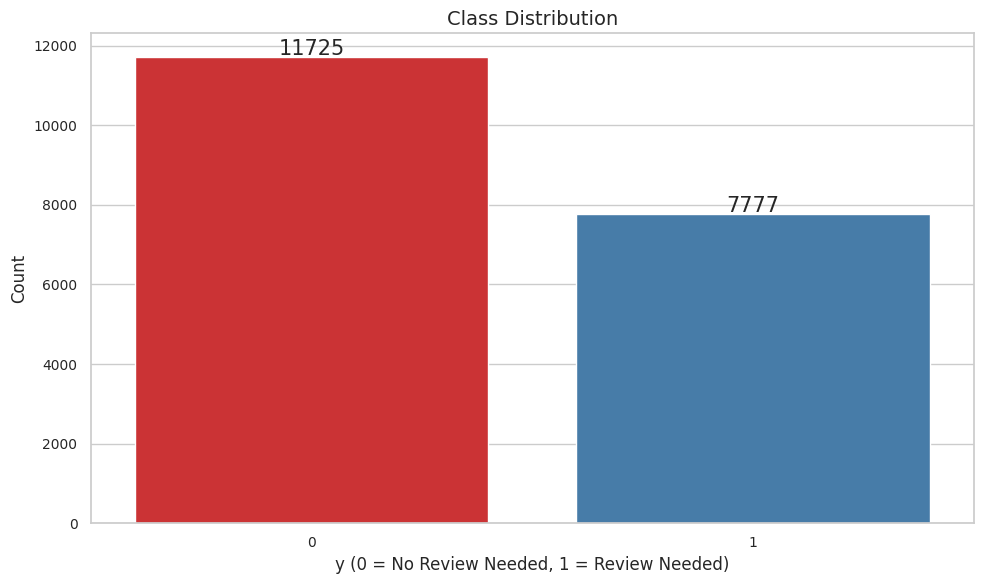

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='y', data=train_ds_cpp_df, palette='Set1', hue='y', legend=False)
plt.title('Class Distribution', fontsize=14)
plt.xlabel('y (0 = No Review Needed, 1 = Review Needed)', fontsize=12)
plt.ylabel('Count', fontsize=12)
ax.tick_params(axis='both', labelsize=10)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 50,
            int(height), ha="center", fontsize=15)

plt.tight_layout()
plt.show()

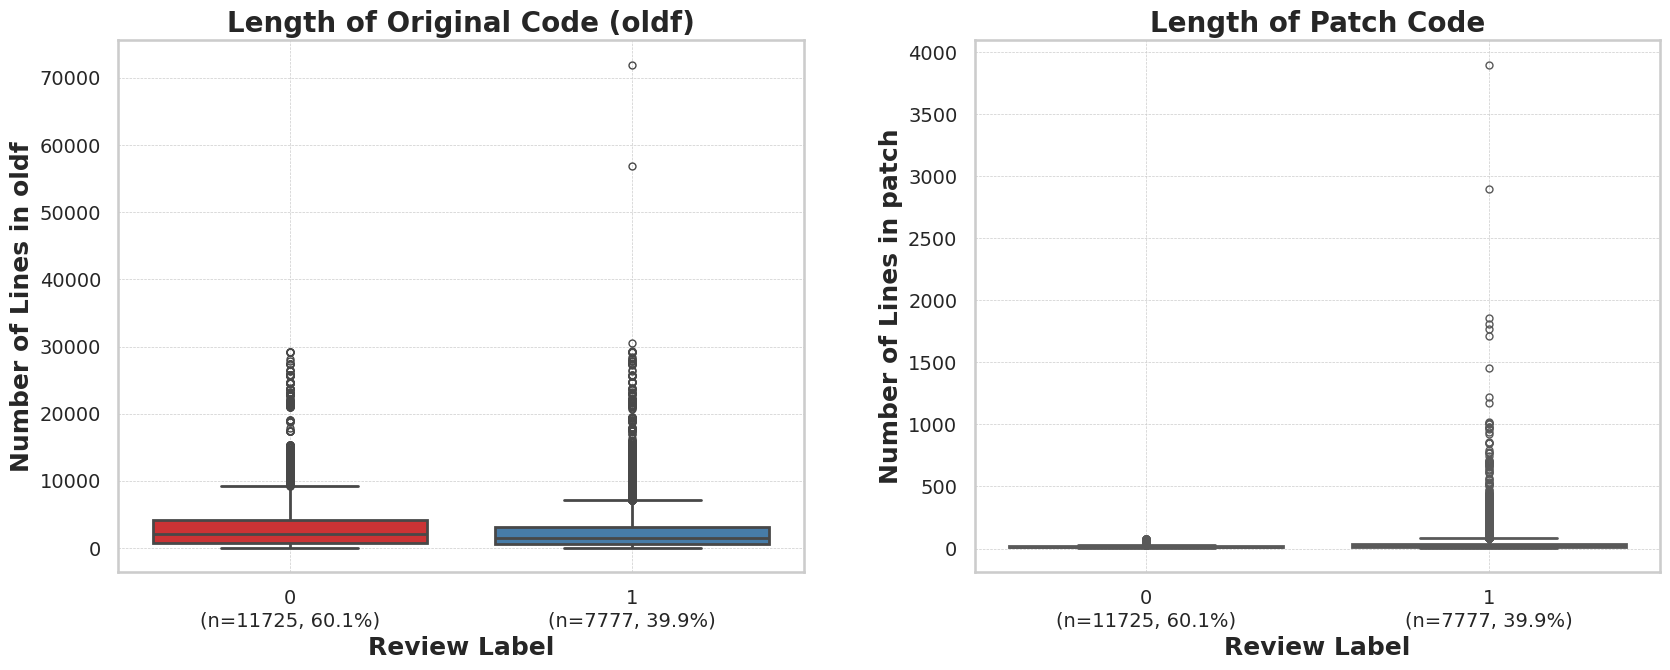

In [ ]:
# Set seaborn style
sns.set(style='whitegrid', context='talk')

# Plot distributions of oldf and patch lengths
plt.figure(figsize=(18, 8))

# Box plot: Old code length by label
plt.subplot(1, 2, 1)
ax1 = sns.boxplot(
    data=train_ds_cpp_df,
    x='y',
    y='oldf_len',
    palette='Set1',
    linewidth=2,
    fliersize=5
)
plt.title('Length of Original Code (oldf)', fontsize=20, fontweight='bold')
ax1.set_xticklabels(labels_with_percent, fontsize=12)
plt.xlabel('Review Label', fontsize=18, fontweight='bold')
plt.ylabel('Number of Lines in oldf', fontsize=18, fontweight='bold')
ax1.tick_params(axis='both', labelsize=14)
ax1.grid(True, linestyle='--', linewidth=0.5)

# Box plot: Patch code length by label
plt.subplot(1, 2, 2)
ax2 = sns.boxplot(
    data=train_ds_cpp_df,
    x='y',
    y='patch_len',
    palette='Set2',
    linewidth=2,
    fliersize=5
)
plt.title('Length of Patch Code', fontsize=20, fontweight='bold')
ax2.set_xticklabels(labels_with_percent, fontsize=12)
plt.xlabel('Review Label', fontsize=18, fontweight='bold')
plt.ylabel('Number of Lines in patch', fontsize=18, fontweight='bold')
ax2.tick_params(axis='both', labelsize=14)
ax2.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout(pad=3)
plt.show()

### **Class Imbalance Mitigation**

The dataset shows an imbalanced distribution of labels:

- **Class 0** (high quality, no further review): 11,725 samples  
- **Class 1** (low quality, requires additional review): 7,777 samples

This imbalance can bias the model toward the majority class, degrading its ability to detect low-quality code changes. To mitigate this, we apply the following strategies:

### **1. Class Weights (Cost-Sensitive Learning)**

We compute class weights inversely proportional to class frequencies to penalize misclassification of the minority class during training.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Number of samples per class
n_samples_class_0 = 11725
n_samples_class_1 = 7777

n_total_samples = n_samples_class_0 + n_samples_class_1
n_classes = 2

weight_0 = n_total_samples / (n_classes * n_samples_class_0)
weight_1 = n_total_samples / (n_classes * n_samples_class_1)

# Create tensor
class_weights = torch.tensor([weight_0, weight_1], dtype=torch.float).to(device)

In [ ]:
print("Class Weights:", class_weights)

### **2. Data Resampling (Input-Level Balancing)**

To address class imbalance at the data level, we use **stratified upsampling** of the minority class:

- **Upsample class 1** using `sklearn.utils.resample`
- **Combine** with class 0 to create a balanced dataset
- **Convert** the result back to a Hugging Face `Dataset` object for model training

In [ ]:
train_ds = train_dataset_cpp['train']

# Separate by class
ds_0 = train_ds.filter(lambda example: example['y'] == 0)
ds_1 = train_ds.filter(lambda example: example['y'] == 1)

target_size = n_samples_class_0
minority_size = n_samples_class_1

# Generate indices for upsampling the minority class
# Create a list of original indices from the minority dataset
minority_indices = list(range(minority_size))

# Randomly sample with replacement from these indices to match the target size
random.seed(42) # Ensure reproducibility
upsampled_indices = random.choices(minority_indices, k=target_size)

# Select the samples using the generated indices
minority_upsampled = ds_1.select(upsampled_indices)

# Combine and shuffle
train_ds_cpp_balanced = concatenate_datasets([ds_0, minority_upsampled]).shuffle(seed=42)

In [ ]:
# Print summary
print(f"Balanced training set size: {len(train_ds_cpp_balanced)} "
      f"(Class 0: {len(ds_0)}, Class 1: {len(minority_upsampled)})")

Balanced training set size: 23450 (Class 0: 11725, Class 1: 11725)


In [ ]:
train_ds_cpp_balanced = DatasetDict({'train': train_ds_cpp_balanced})

### **Extract Diff with Context**

To capture code changes with surrounding context, we extract:

- Modified lines from `patch` (additions and deletions)  
- `context_lines` before and after each change  

Lines are annotated as:

- `[ADD]` for added lines  
- `[DEL]` for deleted lines  

Metadata (e.g., `+++`, `---`, `@@`) is removed to keep the output clean.

In [ ]:
def extract_diff_with_context(old_code: str, patch: str, context_lines: int ) -> str:

    """
    Extracts code changes from a unified diff (`patch`) along with surrounding context lines.

    Parameters:
    ----------
    old_code : str
        Original code before the changes (not used in processing, but retained for interface consistency).

    patch : str
        Unified diff string representing the code changes.

    context_lines : int, optional (default=5)
        Number of lines to include before and after each change for contextual understanding.

    Returns:
    -------
    str
        A formatted string containing:
        - Context lines around each change
        - `[ADD]`-prefixed lines for additions
        - `[DEL]`-prefixed lines for deletions
        - Excludes non-informative diff metadata (e.g., '+++', '---', '@@')

    Example output:
        some unchanged line
        [DEL] removed line
        [ADD] added line
        another unchanged line
    """

    patch_lines = patch.splitlines()
    context_indices = set()

    for i, line in enumerate(patch_lines):
        if line.startswith(('+', '-')) and not line.startswith(('+++', '---')):
            start = max(0, i - context_lines)
            end = min(len(patch_lines), i + context_lines + 1)
            context_indices.update(range(start, end))

    extracted_lines = []
    for i in sorted(context_indices):
        line = patch_lines[i]
        if line.startswith(('@@', '+++', '---')):
            continue
        if line.startswith('+') and not line.startswith('+++'):
            line = '[ADD] ' + line[1:].strip()
        elif line.startswith('-') and not line.startswith('---'):
            line = '[DEL] ' + line[1:].strip()
        extracted_lines.append(line)

    return "\n".join(extracted_lines)

In [ ]:
def apply_extract_diff(example, context_lines=5):
    # Extract diff with context for each example row
    return {
        "extracted_diff": extract_diff_with_context(
            example["oldf"], example["patch"], context_lines=context_lines
        )
    }

In [ ]:
def print_diff_examples(dataset, num_examples, context_lines):

    """
    Print a few examples from the dataset showing the original code, the patch,
    and the extracted diff with context.

    Parameters:
    ----------
        dataset: Each item should have 'oldf' and 'patch'.
        num_examples (int): Number of examples to print.
        context_lines (int): Number of context lines to include.
    """

    for i in range(num_examples):
        example = dataset[i]
        old_code = example.get('oldf', '')
        patch = example.get('patch', '')
        extracted = extract_diff_with_context(old_code, patch, context_lines=context_lines)

        print(f"Example {i + 1}")
        print(extracted)
        print("=" * 60, "\n")

In [ ]:
print_diff_examples(train_ds_cpp_balanced['train'], 3, 5)

Example 1
 
    void connection::enqueue( const net_message& m ) {
       verify_strand_in_this_thread( strand, __func__, __LINE__ );
[ADD] // for tls connections, when the connection is not in the security group
[ADD] // certain message types will not be transmitted
[ADD] if(!is_participating()) {
[ADD] const bool ignore = std::holds_alternative<notice_message>(m) ||
[ADD] std::holds_alternative<signed_block_v0>(m) ||
[ADD] std::holds_alternative<packed_transaction_v0>(m) ||
[ADD] std::holds_alternative<signed_block>(m) ||
[ADD] std::holds_alternative<trx_message_v1>(m);
[ADD] if(ignore) {
[ADD] return;
[ADD] }
[ADD] }
       go_away_reason close_after_send = no_reason;
       if (std::holds_alternative<go_away_message>(m)) {
          close_after_send = std::get<go_away_message>(m).reason;

Example 2
             x = fluid.data(name="data", shape=[None, 32, 32], dtype="float32")
             droped = fluid.layers.dropout(x, dropout_prob=0.5)
     """
[ADD] if in_dygraph_mode():
[ADD]

In [ ]:
train_ds_cpp_balanced = train_ds_cpp_balanced.map(
    apply_extract_diff,
    batched=False,
    remove_columns=None
)

In [ ]:
val_ds_cpp = val_ds_cpp.map(
    apply_extract_diff,
    batched=False,
    remove_columns=None
)

In [ ]:
test_ds_cpp = test_ds_cpp.map(
    apply_extract_diff,
    batched=False,
    remove_columns=None
)

In [ ]:
def count_words_batch(examples):
    return {'word_count': [len(text.split()) for text in examples['extracted_diff']]}

In [ ]:
train_ds_cpp_balanced = train_ds_cpp_balanced.map(count_words_batch, batched=True)
val_ds_cpp = val_ds_cpp.map(count_words_batch, batched=True)
test_ds_cpp = test_ds_cpp.map(count_words_batch, batched=True)

In [ ]:
def count_examples_within_word_limit(dataset_split, word_limit=512):
    """
    Count how many examples in a dataset split have word counts within the given limit.

    Parameters:
    -----------
    dataset_split : Dataset
        A Hugging Face Dataset split (e.g., train_ds_cpp_balanced['train']).
        Assumes it has a 'word_count' field.

    word_limit : int, optional (default=512)
        Maximum number of words allowed to be counted as 'within limit'.

    Prints:
    -------
    Number and percentage of examples with word counts <= word_limit.
    """
    word_counts = dataset_split['word_count']
    total = len(word_counts)
    num_within_limit = sum(1 for wc in word_counts if wc <= word_limit)

    print(f"Examples with ≤ {word_limit} words: {num_within_limit} out of {total}")
    print(f"Percentage: {num_within_limit / total * 100:.2f}%")


In [ ]:
count_examples_within_word_limit(train_ds_cpp_balanced['train'])
count_examples_within_word_limit(val_ds_cpp['train'])
count_examples_within_word_limit(test_ds_cpp['train'])

Examples with ≤ 512 words: 22667 out of 23450
Percentage: 96.66%
Examples with ≤ 512 words: 3112 out of 3112
Percentage: 100.00%
Examples with ≤ 512 words: 3015 out of 3015
Percentage: 100.00%


In [ ]:
# Rename the 'y' column to 'labels' as the model requested
train_ds_cpp_balanced = train_ds_cpp_balanced.rename_column('y', 'labels')
val_ds_cpp = val_ds_cpp.rename_column('y', 'labels')
test_ds_cpp = test_ds_cpp.rename_column('y', 'labels')

##**Tokenization**

Tokenize the combined code changes using CodeBERT’s tokenizer to prepare the input for training.

In [ ]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

# Load and modify the config with custom dropout
config = AutoConfig.from_pretrained("microsoft/codebert-base")
config.num_labels = 2
config.hidden_dropout_prob = 0.3
config.attention_probs_dropout_prob = 0.3  # for attention layers

# Load model with custom config
model = AutoModelForSequenceClassification.from_pretrained("microsoft/codebert-base", config=config)


#### **Adding Custom Special Tokens**

To help the tokenizer recognize semantic tags like `[ADD]` and `[DEL]` (used to mark code insertions and deletions), we register them as special tokens.


In [ ]:
special_tokens_dict = {
    'additional_special_tokens': ['[ADD]', '[DEL]']
}

num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

model.resize_token_embeddings(len(tokenizer))

In [ ]:
def tokenize_function(examples, tokenizer, max_length=512):
    """
    Tokenizes input text and prepares it for model training or evaluation.

    Applies standard tokenization using a Hugging Face tokenizer, with padding and
    truncation to ensure all sequences are of uniform length. Also attaches the
    corresponding labels to the tokenized output.

    Parameters
    ----------
    examples : dict
        A dictionary with the following keys:
        - 'extracted_diff' : List[str]
            A list of input text strings to be tokenized.
        - 'labels' : List[int]
            A list of integer labels corresponding to each input string.

    tokenizer : PreTrainedTokenizer
        A Hugging Face tokenizer instance used to convert text into input IDs
        and attention masks.

    max_length : int, optional (default=512)
        The maximum length for tokenized sequences. Inputs longer than this
        will be truncated, and shorter ones will be padded.

    Returns
    -------
    dict
        A dictionary containing:
        - 'input_ids' : List[List[int]]
            Token IDs for each input string.
        - 'attention_mask' : List[List[int]]
            Attention masks indicating actual tokens vs. padding.
        - 'labels' : List[int]
            The original labels passed alongside the input text.
    """

    tokenized = tokenizer(
        examples['extracted_diff'],
        padding='max_length',
        max_length=max_length,
        truncation=True,
        return_tensors=None
    )

    tokenized["labels"] = examples["labels"]

    return tokenized


In [ ]:
train_ds_cpp_balanced = train_ds_cpp_balanced.map(
    tokenize_function,
    batched=True,
    batch_size=32,
    remove_columns=['oldf','patch','lang','extracted_diff', 'word_count'], # Remove unnecessary columns after tokenizing
    fn_kwargs={"tokenizer": tokenizer, "max_length": 512}
)

In [ ]:
val_ds_cpp = val_ds_cpp.map(
    tokenize_function,
    batched=True,
    batch_size=32,
    remove_columns=['oldf','patch','lang','extracted_diff', 'word_count'], # Remove unnecessary columns after tokenizing
    fn_kwargs={"tokenizer": tokenizer, "max_length": 512}
)

In [ ]:
test_ds_cpp = test_ds_cpp.map(
    tokenize_function,
    batched=True,
    batch_size=32,
    remove_columns=['oldf','patch','lang','extracted_diff', 'word_count'],# Remove unnecessary columns after tokenizing
    fn_kwargs={"tokenizer": tokenizer, "max_length": 512}
)

In [ ]:
# Set dataset format to PyTorch tensors with selected columns for model input and training
train_ds_cpp_balanced.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_ds_cpp.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_ds_cpp.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

## **Training and Fine-Tuning**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class WeightedLossTrainer(Trainer):

    """
    Custom Trainer subclass that applies class weights to the loss function to address class imbalance.

    Parameters:
    ----------
    class_weights : torch.Tensor
        Tensor of weights for each class used during loss computation.
        Applying these weights helps the model focus more on minority classes during training.

    Other parameters are passed to the base Trainer class.

    Methods:
    -------
    compute_loss(model, inputs, return_outputs=False, num_items_in_batch=None)
        Computes the weighted cross-entropy loss using the specified class weights.
    """

    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights


    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):

        """
        Compute weighted cross-entropy loss with class weights.

        Parameters:
        -----------
        model : torch.nn.Module
            The model being trained.
        inputs : dict
            A dictionary containing input tensors, including 'labels'.
        return_outputs : bool, optional (default=False)
            If True, returns a tuple of (loss, model outputs).
        num_items_in_batch : int, optional
            Number of items in the batch (not used in this implementation).

        Returns:
        --------
        torch.Tensor or (torch.Tensor, dict)
            The computed loss, and optionally the model outputs if `return_outputs` is True.
        """

        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


### **Training Arguments Configuration**
We define the training configuration using the TrainingArguments class, specifying essential parameters to control the training loop and evaluation:


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,          # Overwrite output directory if exists
    eval_strategy="steps",              # Evaluate every eval_steps
    per_device_train_batch_size=32,     # Batch size for training
    per_device_eval_batch_size=32,      # Batch size for evaluation
    num_train_epochs=8,                 # Train for 8 epochs
    logging_steps=250,                  # Log every 250 steps
    eval_steps=250,                     # Evaluate every 250 steps
    save_steps=250,                     # Save checkpoint every 250 steps
    save_total_limit=3,                 # Keep only the 3 latest checkpoints
    load_best_model_at_end=True,        # Load best model at end
    metric_for_best_model="f1",         # Use F1 to choose best model
    greater_is_better=True,             # Higher F1 is better
    fp16=True,                          # Use mixed precision
    learning_rate=2e-5,                 # learning rate
    weight_decay=0.01,                  # Weight decay for regularization
    warmup_ratio=0.1,                   # Warmup 10% steps
    gradient_accumulation_steps=4,      # Gradient accumulation
    dataloader_num_workers=4,           # More workers for data loading
    seed=42,                            # Seed for reproducibility
    logging_dir="./logs",
    report_to="none",
)

In [ ]:
def compute_metrics(eval_pred) -> dict:

    """
    Computes evaluation metrics based on model predictions and true labels.

    Parameters
    ----------
    eval_pred : tuple
        A tuple containing logits (np.ndarray) and true labels (np.ndarray).

    Returns
    -------
    dict
        A dictionary with accuracy, F1 score, precision, and recall (all weighted).
    """

    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted'),
        'precision': precision_score(labels, preds, average='weighted'),
        'recall': recall_score(labels, preds, average='weighted')
    }

In [ ]:
# Set up the trainer to train the model with class weights, evaluation, and early stopping.
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_cpp_balanced['train'],
    eval_dataset=val_ds_cpp['train'],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    class_weights=class_weights
)

In [ ]:
# Train the model.
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
250,0.601600,0.654022,0.653278,0.640624,0.641960,0.653278
500,0.519200,0.726093,0.651992,0.635486,0.639514,0.651992
750,0.478800,0.685226,0.651350,0.642861,0.641858,0.651350
1000,0.447300,0.762441,0.660668,0.651893,0.651509,0.660668
1250,0.429500,0.759083,0.651028,0.649431,0.648255,0.651028


TrainOutput(global_step=1472, training_loss=0.4825628270273623, metrics={'train_runtime': 4193.672, 'train_samples_per_second': 44.734, 'train_steps_per_second': 0.351, 'total_flos': 4.9359633985536e+16, 'train_loss': 0.4825628270273623, 'epoch': 8.0})

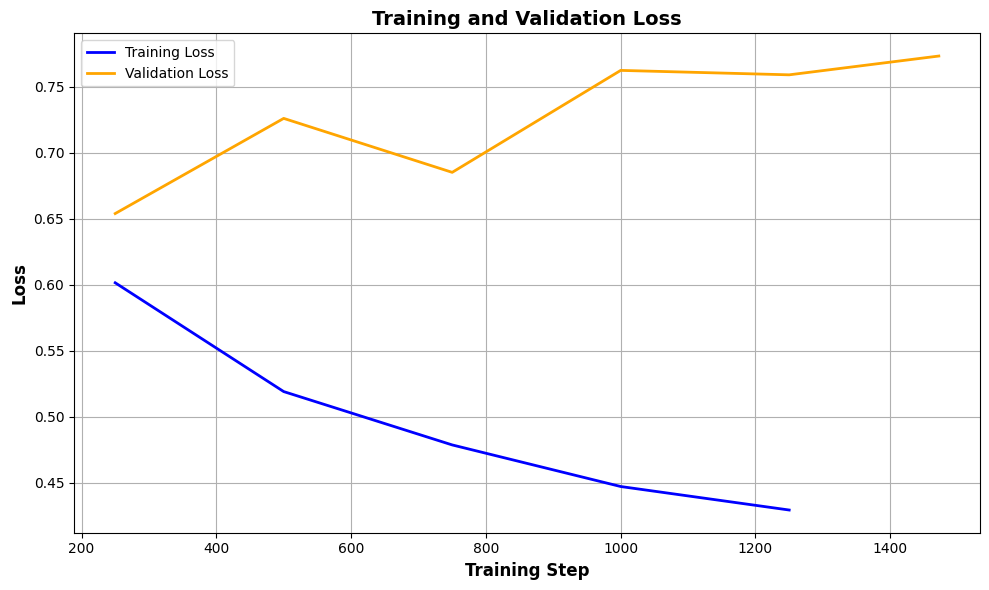

In [ ]:
# Extract logs from trainer
logs = trainer.state.log_history

# Training loss
train_steps = [log["step"] for log in logs if "loss" in log]
train_losses = [log["loss"] for log in logs if "loss" in log]
train_smooth = pd.Series(train_losses).rolling(window=5).mean()

# Validation loss
val_steps = [log["step"] for log in logs if "eval_loss" in log]
val_losses = [log["eval_loss"] for log in logs if "eval_loss" in log]

plt.figure(figsize=(10, 6))

# Original losses
plt.plot(train_steps, train_losses, label="Training Loss", color="blue", linewidth=2)
plt.plot(val_steps, val_losses, label="Validation Loss", color="orange", linewidth=2)

# Formatting
plt.xlabel("Training Step", fontsize=12, fontweight='bold')
plt.ylabel("Loss", fontsize=12, fontweight='bold')
plt.title("Training and Validation Loss", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


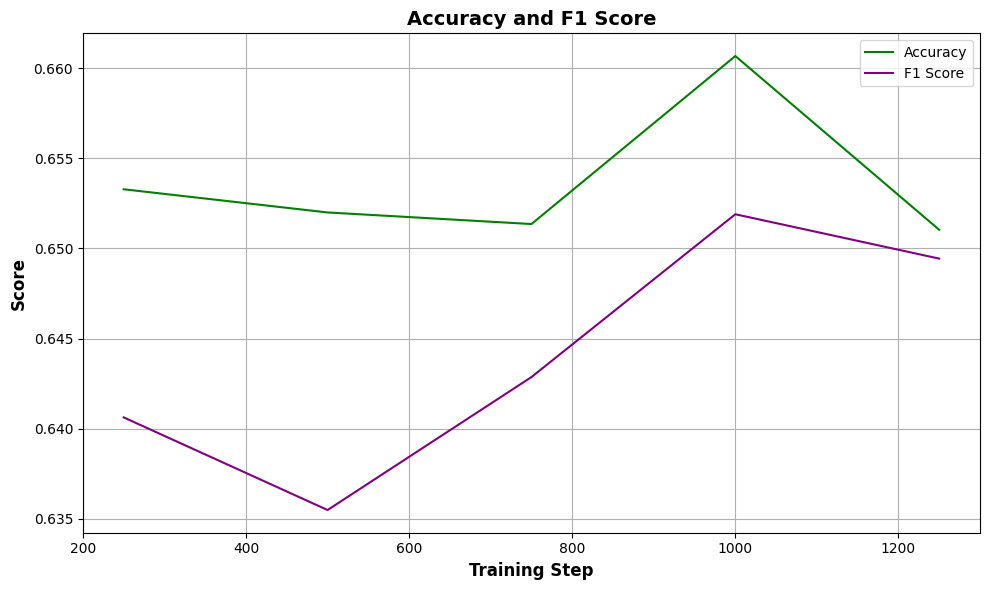

In [ ]:
# Accuracy
acc_steps = [log["step"] for log in logs if "eval_accuracy" in log]
acc_scores = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]

# F1
f1_steps = [log["step"] for log in logs if "eval_f1" in log]
f1_scores = [log["eval_f1"] for log in logs if "eval_f1" in log]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(acc_steps, acc_scores, label="Accuracy", color="green")
plt.plot(f1_steps, f1_scores, label="F1 Score", color="purple",)

plt.xlabel("Training Step",fontsize=12,fontweight='bold')
plt.ylabel("Score",fontsize=12,fontweight='bold')
plt.title("Accuracy and F1 Score",fontsize=14,fontweight='bold')
plt.legend()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## **Evaluation**

In [ ]:
trainer.evaluate(test_ds_cpp['train'])

{'eval_loss': 0.7733169198036194,
 'eval_accuracy': 0.6517412935323383,
 'eval_f1': 0.6431495355895097,
 'eval_precision': 0.641264590995093,
 'eval_recall': 0.6517412935323383,
 'eval_runtime': 19.6673,
 'eval_samples_per_second': 153.3,
 'eval_steps_per_second': 4.83,
 'epoch': 8.0}

In [ ]:
# Run prediction on the test dataset to get logits and labels
pred_output = trainer.predict(test_ds_cpp['train'])

In [ ]:
logits = pred_output.predictions
labels = pred_output.label_ids

# Convert logits to predicted classes
preds = np.argmax(logits, axis=1)

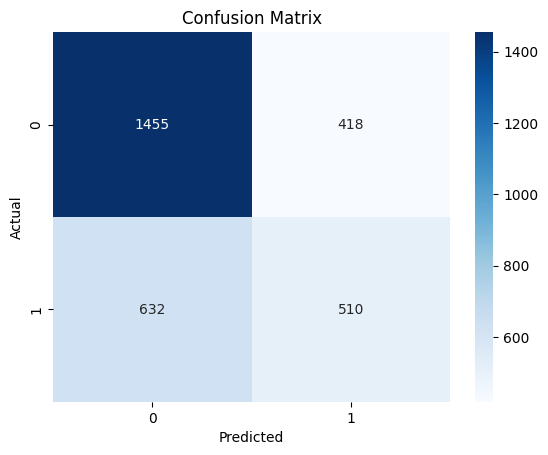

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(labels, preds, digits=4))

              precision    recall  f1-score   support

           0     0.6972    0.7768    0.7348      1873
           1     0.5496    0.4466    0.4928      1142

    accuracy                         0.6517      3015
   macro avg     0.6234    0.6117    0.6138      3015
weighted avg     0.6413    0.6517    0.6431      3015

